# Supervised Learning Capstone Presentation

## Exploring Wage Disparities Across Occupations

In this notebook I will be exploring the Kaggle dataset of the US Bureau of Labor Statistics January 2015 report on income by gender and occupation. The dataset's metadata states that it shows 535 different occupations, and their corresponding weekly median incomes, broken down into men, women, and all, columns. Also included are reported numbers of emplyees for each occupation.

With this data, I would like to see if I can predict the occupational category of a job given input on wage, gender, share of females, gender ratio, wage gap, and if the field is male dominated or has a significant wage gap. 



### A few things to acknowledge before we get started. 

We are going to be using a few different modules for this experiment, including SKLearn heavily. Pandas, Numpy, and Seaborn are here as well. We will be measuring how well we are doing using the different models built in scoring mechanism and also sklearn.metrics accuracy_score, which measures your predicted labels compared to your correct labels. 

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn import tree
from sklearn import ensemble
from sklearn.model_selection import cross_val_score, train_test_split
%matplotlib inline

In [4]:
import os
curr_directory = os.getcwd()
datafile = curr_directory + "/inc_occ_gender.csv"


Taking our first look at our data, it looks like the occupation categories are all upper case. There are also a few columns of objects that have numerical values in them. We'll change those over, coercing them to have nan values which we can later drop.

In [5]:
genderwage = pd.read_csv(datafile)
genderwage.head()

,Occupation,All_workers,All_weekly,M_workers,M_weekly,F_workers,F_weekly
0,ALL OCCUPATIONS,109080,809,60746,895,48334,726
1,MANAGEMENT,12480,1351,7332,1486,5147,1139
2,Chief executives,1046,2041,763,2251,283,1836
3,General and operations managers,823,1260,621,1347,202,1002
4,Legislators,8,Na,5,Na,4,Na


In [6]:
genderwage.count()

Occupation     558
All_workers    558
All_weekly     558
M_workers      558
M_weekly       558
F_workers      558
F_weekly       558
dtype: int64

In [7]:
genderwage.dtypes

Occupation     object
All_workers     int64
All_weekly     object
M_workers       int64
M_weekly       object
F_workers       int64
F_weekly       object
dtype: object

In [8]:
genderwage[['All_weekly',
            'M_weekly',
            'F_weekly']] = genderwage[['All_weekly',
                                       'M_weekly',
                                       'F_weekly']].apply(pd.to_numeric, errors='coerce')

In [9]:
genderwage.dtypes

Occupation      object
All_workers      int64
All_weekly     float64
M_workers        int64
M_weekly       float64
F_workers        int64
F_weekly       float64
dtype: object

In [10]:
genderwage.isnull().sum()

Occupation       0
All_workers      0
All_weekly     236
M_workers        0
M_weekly       326
F_workers        0
F_weekly       366
dtype: int64

In [11]:
categories = [] 
for i in genderwage['Occupation']:
    if i.isupper()==True:
        categories.append(i)

categories_df = genderwage.loc[genderwage['Occupation'].isin(categories)].reset_index(drop=True).copy()


In [12]:
indices =[]
category_index = pd.Index(list(genderwage['Occupation']))
for i in categories:
    index = category_index.get_loc(i)
    indices.append(index)

In [13]:
genderwage.insert(1, 'Occupation_Category', 0)

In [14]:
cat_count = -1
index_copy = pd.Index(list(genderwage['Occupation']))
for x in genderwage['Occupation']:
    current_index = index_copy.get_loc(x)
    genderwage.iloc[current_index, genderwage.columns.get_loc('Occupation_Category')] = cat_count
    if x.isupper():
        cat_count = cat_count + 1
        genderwage.iloc[current_index, genderwage.columns.get_loc('Occupation_Category')] = cat_count
    

In [15]:
genderwage.insert(1, 'Occupation_Category_label', 0)

In [16]:
cat_label = 'nothing'
for x in genderwage['Occupation']:
    current_index = index_copy.get_loc(x)
    genderwage.iloc[current_index, genderwage.columns.get_loc('Occupation_Category_label')] = cat_label
    if x.isupper():
        cat_label = x
        genderwage.iloc[current_index, genderwage.columns.get_loc('Occupation_Category_label')] = cat_label
    

Setting up our cleaned dataframe, we drop all 'Nan' values, and also pluck out the occupation categories, then reset the index. 


In [23]:
cleanedgenderwage = genderwage.dropna(axis=0, how='any').copy()
cleanedgenderwage = cleanedgenderwage.loc[~cleanedgenderwage['Occupation'].isin(categories)].reset_index(drop=True)


In [24]:
cleanedgenderwage['Occupation_Category_label'].value_counts()

OFFICE                     17
MANAGEMENT                 16
BUSINESS                   12
PRODUCTION                 11
SALES                      11
HEALTHCARE PROFESSIONAL     7
CULINARY                    7
COMPUTATIONAL               7
TRANSPORTATION              4
EDUCATION                   4
PROTECTIVE SERVICE          3
ARTS                        3
SCIENCE                     3
SOCIAL SERVICE              3
SERVICE                     3
GROUNDSKEEPING              3
ENGINEERING                 2
AGRICULTURAL                1
HEALTHCARE SUPPORT          1
LEGAL                       1
Name: Occupation_Category_label, dtype: int64

If we want to create a model that can work well with new information, we need to have categories that are not so narrow. To solve this problem, we're going to combine a few of them. Healthcare Support will be merged with Healthcare Professional, to become simply Healthcare. Agriculture, Construction, Maintenance, Transportation and Groundskeeping are all things we as a society need to continue, so they will all be rolled in to Infrastructure Support. Education will be rolled into Social Service, because both Education and Social Service jobs are focused on bettering people. Engineering will be added to Science, because it's a science, and finally Protective Service, Service, Arts, and Legal will all be put into Other because of their low count.

In [83]:
# combine categories 
cleanedgenderwage.loc[cleanedgenderwage['Occupation_Category_label'] == 'HEALTHCARE SUPPORT', 'Occupation_Category_label'] = 'HEALTHCARE'
cleanedgenderwage.loc[cleanedgenderwage['Occupation_Category_label'] == 'HEALTHCARE PROFESSIONAL', 'Occupation_Category_label'] = 'HEALTHCARE'

cleanedgenderwage.loc[cleanedgenderwage['Occupation_Category_label'] == 'AGRICULTURAL', 'Occupation_Category_label'] = 'INFRASTRUCTURE SUPPORT'
cleanedgenderwage.loc[cleanedgenderwage['Occupation_Category_label'] == 'CONSTRUCTION', 'Occupation_Category_label'] = 'INFRASTRUCTURE SUPPORT'
cleanedgenderwage.loc[cleanedgenderwage['Occupation_Category_label'] == 'MAINTENANCE', 'Occupation_Category_label'] = 'INFRASTRUCTURE SUPPORT'
cleanedgenderwage.loc[cleanedgenderwage['Occupation_Category_label'] == 'GROUNDSKEEPING', 'Occupation_Category_label'] = 'INFRASTRUCTURE SUPPORT'
cleanedgenderwage.loc[cleanedgenderwage['Occupation_Category_label'] == 'TRANSPORTATION', 'Occupation_Category_label'] = 'INFRASTRUCTURE SUPPORT'

cleanedgenderwage.loc[cleanedgenderwage['Occupation_Category_label'] == 'ENGINEERING', 'Occupation_Category_label'] = 'SCIENCE'

cleanedgenderwage.loc[cleanedgenderwage['Occupation_Category_label'] == 'EDUCATION', 'Occupation_Category_label'] = 'SOCIAL SERVICE'

cleanedgenderwage.loc[cleanedgenderwage['Occupation_Category_label'] == 'PROTECTIVE SERVICE', 'Occupation_Category_label'] = 'OTHER'
cleanedgenderwage.loc[cleanedgenderwage['Occupation_Category_label'] == 'SERVICE', 'Occupation_Category_label'] = 'OTHER'
cleanedgenderwage.loc[cleanedgenderwage['Occupation_Category_label'] == 'ARTS', 'Occupation_Category_label'] = 'OTHER'
cleanedgenderwage.loc[cleanedgenderwage['Occupation_Category_label'] == 'LEGAL', 'Occupation_Category_label'] = 'OTHER'


In [84]:
cleanedgenderwage['Occupation_Category_label'].value_counts()

OFFICE                    17
MANAGEMENT                16
BUSINESS                  12
PRODUCTION                11
SALES                     11
OTHER                      9
INFRASTRUCTURE SUPPORT     8
SOCIAL SERVICE             8
HEALTHCARE                 8
COMPUTATIONAL              7
CULINARY                   7
SCIENCE                    5
Name: Occupation_Category_label, dtype: int64

## Preliminary Data Exploration

Here we will take a look at the distributions of male to female workers, male to female wages, and finally see a scatter plot of male to female wages.

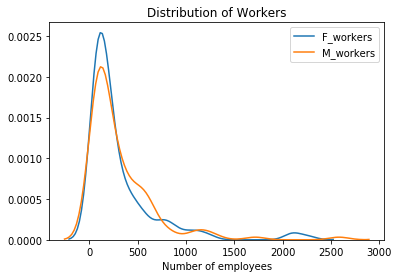

In [72]:
sns.kdeplot(data=cleanedgenderwage['F_workers'])
sns.kdeplot(data=cleanedgenderwage['M_workers'])
plt.xlabel('Number of employees')
plt.title('Distribution of Workers')
plt.show()

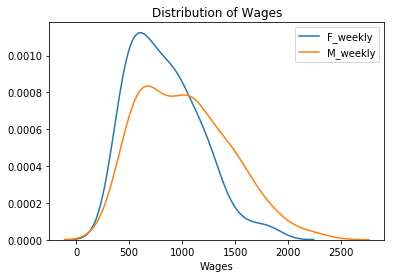

In [74]:
sns.kdeplot(data=cleanedgenderwage['F_weekly'])
sns.kdeplot(data=cleanedgenderwage['M_weekly'])
plt.title('Distribution of Wages')
plt.xlabel('Wages')
plt.show()

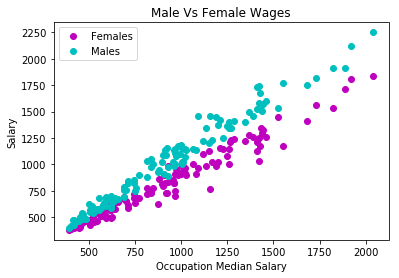

In [75]:
# look at female wages vs male wages on a scatter plot
plt.plot(cleanedgenderwage['All_weekly'], cleanedgenderwage['F_weekly'], 'o', color='m')
plt.plot(cleanedgenderwage['All_weekly'], cleanedgenderwage['M_weekly'], 'o', color='c')
plt.xlabel('Occupation Median Salary')
plt.legend(['Females','Males'])
plt.title('Male Vs Female Wages')
plt.ylabel('Salary')
plt.show()

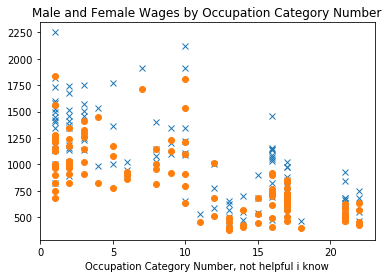

In [104]:
plt.plot(cleanedgenderwage['Occupation_Category'], cleanedgenderwage['M_weekly'], 'x')
plt.plot(cleanedgenderwage['Occupation_Category'], cleanedgenderwage['F_weekly'], 'o')
plt.xlabel('Occupation Category Number, not helpful i know')
plt.title('Male and Female Wages by Occupation Category Number')
plt.show()

Across all categories men get paid more than women. And there seems to be a down

In [77]:
categories

['ALL OCCUPATIONS',
 'MANAGEMENT',
 'BUSINESS',
 'COMPUTATIONAL',
 'ENGINEERING',
 'SCIENCE',
 'SOCIAL SERVICE',
 'LEGAL',
 'EDUCATION',
 'ARTS',
 'HEALTHCARE PROFESSIONAL',
 'HEALTHCARE SUPPORT',
 'PROTECTIVE SERVICE',
 'CULINARY',
 'GROUNDSKEEPING',
 'SERVICE',
 'SALES',
 'OFFICE',
 'AGRICULTURAL',
 'CONSTRUCTION',
 'MAINTENANCE',
 'PRODUCTION',
 'TRANSPORTATION']

# Now lets create some features

talk about wage gap ratio feature and why you made it

Again, talk about why you made the gender ratio

Then I made two complimentary columns of the mens and womens share of workers by dividing each by all workers. The colinearity of these features is noted. talk more here

In [31]:
cleanedgenderwage['WageGap_as_Ratio'] = cleanedgenderwage['F_weekly'] / cleanedgenderwage['M_weekly']
#cleanedgenderwage['GenderRatio'] = cleanedgenderwage['F_workers'] / cleanedgenderwage['M_workers']
cleanedgenderwage['F_share'] = cleanedgenderwage['F_workers'] / cleanedgenderwage['All_workers']
cleanedgenderwage['M_share'] = cleanedgenderwage['M_workers'] / cleanedgenderwage['All_workers']

## Next I marked which occupations are male dominated

Any ratio under .85 is considered male dominated as that shows a 15% or more majority over women.

## I also made a column marking occupations with significant wage gaps

For our purposes, a significant wage gap is a difference of 15% or more over women.

In [33]:
cleanedgenderwage['Male_Dominated'] = np.where(cleanedgenderwage['GenderRatio'] > .85, 0, 1)
cleanedgenderwage['Significant_wage_gap'] = np.where(cleanedgenderwage['WageGap_as_Ratio'] > .85, 0, 1)

## Lets plot some of these new features

We'll look at a distribution plot of the wage gap, bar plots of weekly income by occupation, wage gap by occupation, gender ratio by occupation, wage ratio by occupation, and a scatter plot of mens weekly income and womens weekly income as a function of the reported occupation median income, color coded to each occupation.

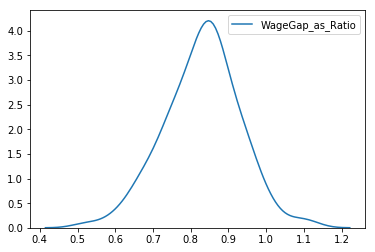

In [69]:
sns.kdeplot(data=cleanedgenderwage['WageGap_as_Ratio'])
plt.show()

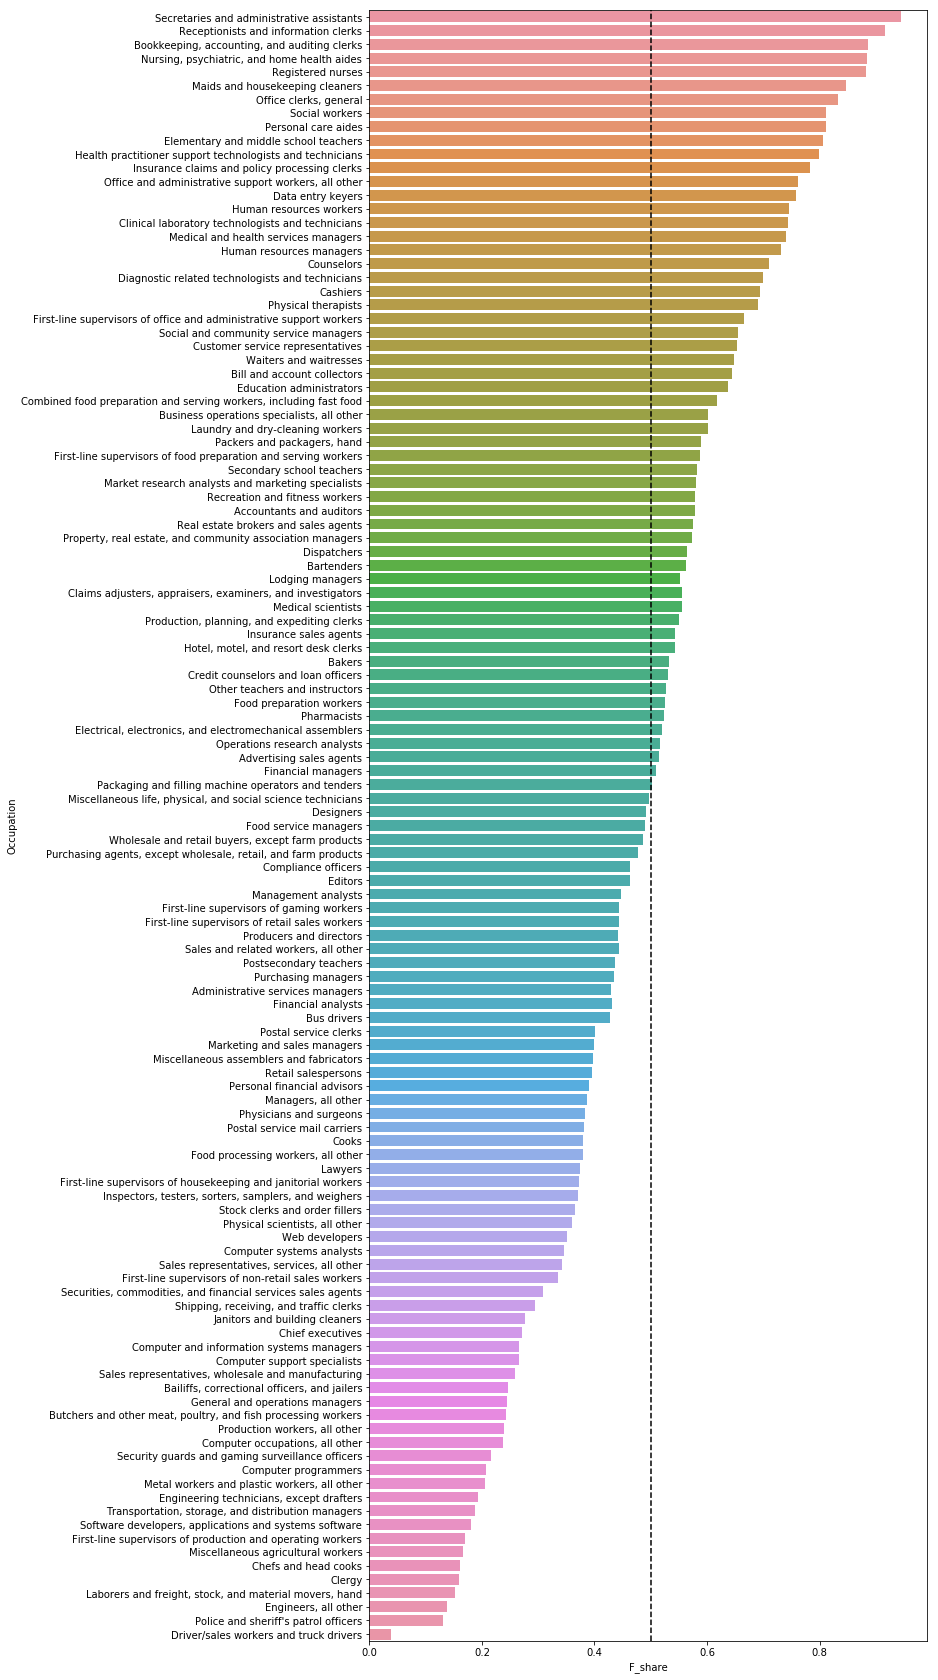

In [139]:

# Now lets look at the ratio of workers
plt.figure(figsize=((10,30)))
sns.barplot(x='F_share',
            y='Occupation',
            data=cleanedgenderwage.sort_values('GenderRatio', ascending=False))
plt.axvline(x=.5, color='black', linestyle='--') # equality at 50%
plt.show()

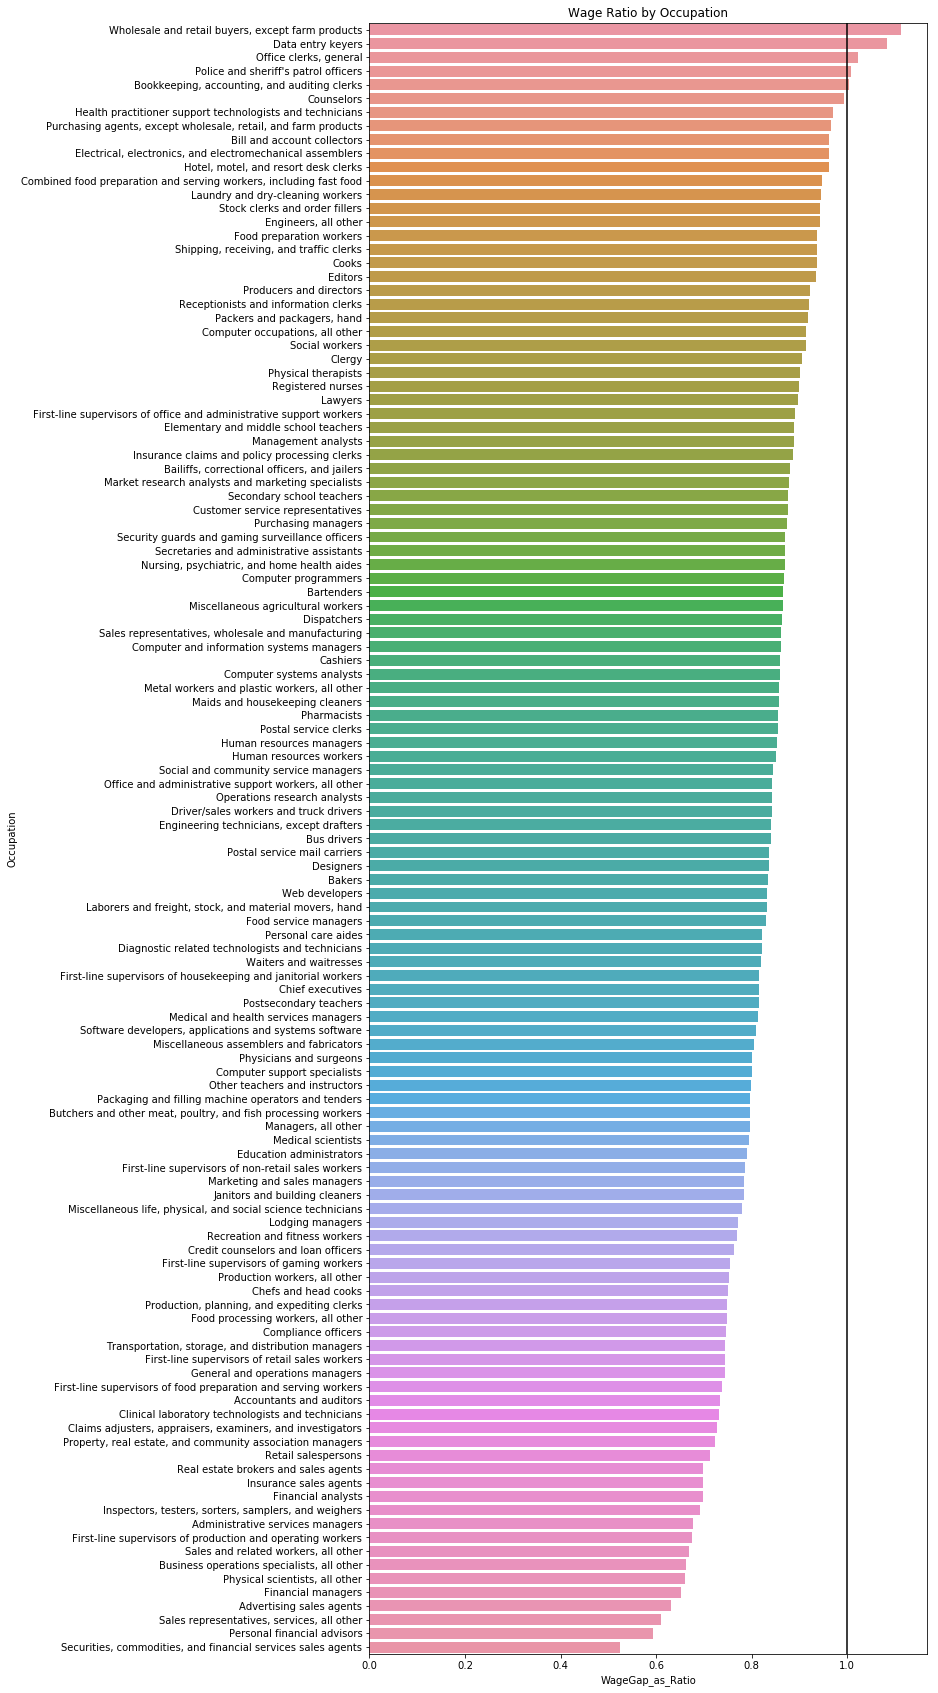

In [78]:
# Look at wage ratio by occupation
plt.figure(figsize=((10,30)))
sns.barplot(x='WageGap_as_Ratio',
            y='Occupation',
            data=cleanedgenderwage.sort_values('WageGap_as_Ratio', ascending=False))
plt.axvline(x=1, color='black', linestyle='solid')
plt.title('Wage Ratio by Occupation')
plt.show()

# Lets look at a bigger scatter plot of m/f incomes, and color it according to occupation

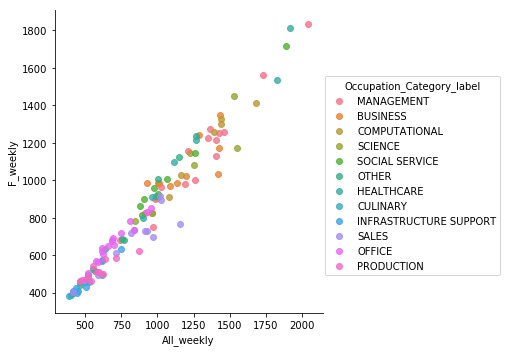

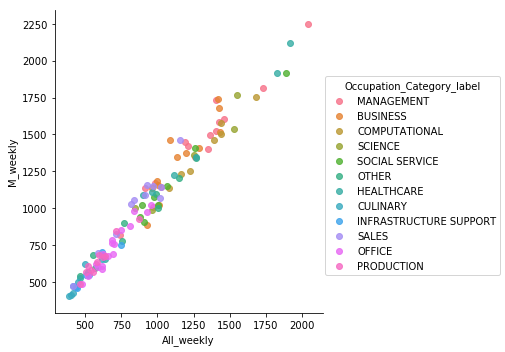

In [141]:
sns.lmplot( x='All_weekly', y='F_weekly', data=cleanedgenderwage, fit_reg=False, hue='Occupation_Category_label', legend=True)
sns.lmplot( x='All_weekly', y='M_weekly', data=cleanedgenderwage, fit_reg=False, hue='Occupation_Category_label', legend=True)
 
plt.show()

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

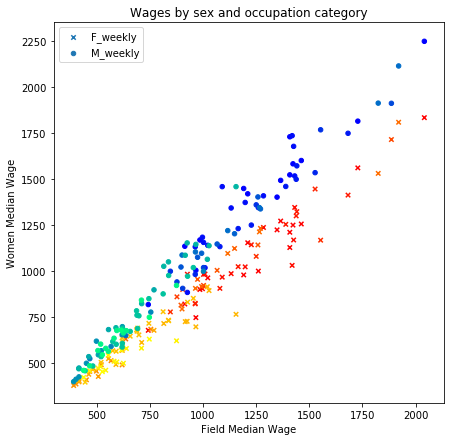

In [114]:
# plot wage by gender and color by occupation category
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
ax.set_title("Wages by sex and occupation category")
ax.set_xlabel("Field Median Wage")
ax.set_ylabel("Women Median Wage")
x = cleanedgenderwage['All_weekly']
y = cleanedgenderwage['F_weekly']
y2 = cleanedgenderwage['M_weekly']
colors = [str(item) for item in cleanedgenderwage['Occupation_Category_label']]

ax.scatter(x, y, s=20, c=cleanedgenderwage['Occupation_Category'], marker = 'x', cmap=plt.cm.autumn)
ax.scatter(x, y2 ,s=20, c=cleanedgenderwage['Occupation_Category'], marker = 'o', cmap=plt.cm.winter)
plt.legend()
plt.colorbar()
plt.show()


# Time for some MODELS

we will be reviewing linear or logisitic regression classifier, then lasso regression classifier, then a random forest classifier

The questions I will be looking to answer today is:
     - Can we predict the occupational category given wage, gender, share of females for that field, if that field is male dominated or not, and if that field has a significant wage gap? 



In [135]:
# make new dfs here
F_df = pd.DataFrame()
M_df = pd.DataFrame()

# make category variable for gender
F_df['Wage'] = cleanedgenderwage['F_weekly']
M_df['Wage'] = cleanedgenderwage['M_weekly']

F_df['Gender'] = np.ones(len(cleanedgenderwage))
M_df['Gender'] = np.zeros(len(cleanedgenderwage))

F_df['Occupation_Category'] = cleanedgenderwage['Occupation_Category_label']
M_df['Occupation_Category'] = cleanedgenderwage['Occupation_Category_label']

F_df['WageGap_as_Ratio'] = cleanedgenderwage['WageGap_as_Ratio']
M_df['WageGap_as_Ratio'] = cleanedgenderwage['WageGap_as_Ratio']

F_df['GenderRatio'] = cleanedgenderwage['GenderRatio']
M_df['GenderRatio'] = cleanedgenderwage['GenderRatio']

F_df['Male_Dominated'] = cleanedgenderwage['Male_Dominated']
M_df['Male_Dominated'] = cleanedgenderwage['Male_Dominated']

F_df['Significant_wage_gap'] = cleanedgenderwage['Significant_wage_gap']
M_df['Significant_wage_gap'] = cleanedgenderwage['Significant_wage_gap']


F_df['F_share'] = cleanedgenderwage['F_share']
M_df['F_share'] = cleanedgenderwage['F_share']

F_df['Occupation_Median_wage'] = cleanedgenderwage['All_weekly']
M_df['Occupation_Median_wage'] = cleanedgenderwage['All_weekly']

combined_df = F_df.append(M_df)



In [136]:
combined_df.head()

,Wage,Gender,Occupation_Category,WageGap_as_Ratio,GenderRatio,Male_Dominated,Significant_wage_gap,F_share,Occupation_Median_wage
0,1836.0,1.0,MANAGEMENT,0.815637,0.370904,1,1,0.270554,2041.0
1,1002.0,1.0,MANAGEMENT,0.743875,0.325282,1,1,0.245443,1260.0
2,1258.0,1.0,MANAGEMENT,0.784779,0.663158,1,1,0.398734,1462.0
3,981.0,1.0,MANAGEMENT,0.676085,0.760417,1,1,0.429412,1191.0
4,1563.0,1.0,MANAGEMENT,0.860209,0.362661,1,0,0.265723,1728.0


I want to try several different classifiers so I'll make a quick function that will allow me to choose the model to test, the data, and then will return me an accuracy score. 

In [41]:
def model_testing(model, X_test, y_test, X_train, y_train):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    scored_model_train = model.score(X_train, y_train)
    scored_model_test = model.score(X_test, y_test)
    model_accuracy = accuracy_score(y_test, y_pred)
    print("Model Score with Training data:")
    print(scored_model_train)
    print("Model Score with Testing data:")
    print(scored_model_test)
    print("Accuracy Score")
    print(model_accuracy)
   

In [89]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(k_neighbors=3, ratio=1, kind='regular')

## Next steps are to scale our data, split it up and resample our training data, then test our models.

In [121]:
# scale columns here
scaler = StandardScaler()
columns = ['Wage',
           'Male_Dominated',
           'Significant_wage_gap',
           'WageGap_as_Ratio',
           'Gender',
           'F_share', 
           'GenderRatio']

# split up data first, then resample only the training data, maybe try smote again
X = combined_df[columns]

X_std = StandardScaler().fit_transform(X)
y = combined_df['Occupation_Category']

X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=.35)

# try smote again
X_smote, y_smote = smote.fit_sample(X_train, y_train)

/anaconda/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


In [122]:
len(X_smote)

252

In [123]:
forest = ensemble.RandomForestClassifier(n_estimators=300, max_depth=3)
model_testing(forest, X_test, y_test, X_smote, y_smote)

Model Score with Training data:
0.6666666666666666
Model Score with Testing data:
0.38095238095238093
Accuracy Score
0.38095238095238093


In [124]:
from sklearn.svm import SVC
svc = SVC()
model_testing(svc, X_test, y_test, X_smote, y_smote)

Model Score with Training data:
0.5952380952380952
Model Score with Testing data:
0.2976190476190476
Accuracy Score
0.2976190476190476


In [125]:
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier()
model_testing(dtree, X_test, y_test, X_smote, y_smote)

Model Score with Training data:
1.0
Model Score with Testing data:
0.4166666666666667
Accuracy Score
0.4166666666666667


In [126]:
extree = ensemble.ExtraTreesClassifier()
model_testing(extree, X_test, y_test, X_smote, y_smote)

Model Score with Training data:
1.0
Model Score with Testing data:
0.4880952380952381
Accuracy Score
0.4880952380952381


In [127]:
gradient = ensemble.GradientBoostingClassifier()
model_testing(gradient, X_test, y_test, X_smote, y_smote)

Model Score with Training data:
1.0
Model Score with Testing data:
0.5833333333333334
Accuracy Score
0.5833333333333334


The tpp three performing models were the decision tree classifier, the extra trees classifier and the gradient boosting classifier. 

Next we will use SKLearn's built in tool GridSearchCV to find the best hyperparameters.

In [99]:
from sklearn.model_selection import GridSearchCV

extra_tree_param = {'criterion': ('gini', 'entropy'),
                    'max_depth': (2, 3, 5),
                    'n_estimators': (10, 50, 100)}
decision_tree_param = {'criterion': ('gini', 'entropy'),
                       'max_depth': (2, 3, 5)}
gradient_param = {'learning_rate': (.01, .5, 1),
                   'n_estimators':(100, 150, 200),
                   'max_depth':(2, 3, 4, 5, 6)}

def check_grid(estimator, params):
    grid_classifier = GridSearchCV(estimator=estimator, param_grid=params)
    grid_classifier.fit(X_std, y)
    grid_score = grid_classifier.score(X_std, y)
    print(grid_score)

In [100]:
check_grid(dtree, decision_tree_param)

0.6722689075630253


In [101]:
check_grid(extree, extra_tree_param)

0.7521008403361344


In [57]:
check_grid(gradient, gradient_param)

1.0


In [102]:
# get params here for best model
grid_cv = GridSearchCV(estimator=gradient, param_grid=gradient_params)
grid_cv.get_params()

{'cv': None,
 'error_score': 'raise',
 'estimator': GradientBoostingClassifier(criterion='friedman_mse', init=None,
               learning_rate=0.1, loss='deviance', max_depth=3,
               max_features=None, max_leaf_nodes=None,
               min_impurity_decrease=0.0, min_impurity_split=None,
               min_samples_leaf=1, min_samples_split=2,
               min_weight_fraction_leaf=0.0, n_estimators=100,
               presort='auto', random_state=None, subsample=1.0, verbose=0,
               warm_start=False),
 'estimator__criterion': 'friedman_mse',
 'estimator__init': None,
 'estimator__learning_rate': 0.1,
 'estimator__loss': 'deviance',
 'estimator__max_depth': 3,
 'estimator__max_features': None,
 'estimator__max_leaf_nodes': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_impurity_split': None,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__n_estimators': 100,
 'estim

In [143]:
tree_cv = GridSearchCV(estimator=extree, param_grid=extra_tree_param)
grid_cv.get_params()

{'cv': None,
 'error_score': 'raise',
 'estimator': GradientBoostingClassifier(criterion='friedman_mse', init=None,
               learning_rate=0.1, loss='deviance', max_depth=3,
               max_features=None, max_leaf_nodes=None,
               min_impurity_decrease=0.0, min_impurity_split=None,
               min_samples_leaf=1, min_samples_split=2,
               min_weight_fraction_leaf=0.0, n_estimators=100,
               presort='auto', random_state=None, subsample=1.0, verbose=0,
               warm_start=False),
 'estimator__criterion': 'friedman_mse',
 'estimator__init': None,
 'estimator__learning_rate': 0.1,
 'estimator__loss': 'deviance',
 'estimator__max_depth': 3,
 'estimator__max_features': None,
 'estimator__max_leaf_nodes': None,
 'estimator__min_impurity_decrease': 0.0,
 'estimator__min_impurity_split': None,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__n_estimators': 100,
 'estim

In [ ]:
# Put model validation here
gradient_validate = GradientBoostingClassifier(criterion='friedman_mse', init=None,
               learning_rate=0.1, loss='deviance', max_depth=3,
               max_features=None, max_leaf_nodes=None,
               min_impurity_decrease=0.0, min_impurity_split=None,
               min_samples_leaf=1, min_samples_split=2,
               min_weight_fraction_leaf=0.0, n_estimators=100,
               presort='auto', random_state=None, subsample=1.0, verbose=0,
               warm_start=False)


# Put conclusion here